# A more complex example

Try to emulate Arnau's analysis

## Visualise the PDFS


{'sig': 2352.9411764705883, 'misrec1': 588.2352941176471, 'misrec2': 588.2352941176471, 'partreclow': 588.2352941176471, 'partrechigh': 1176.4705882352941, 'bkg': 4705.882352941177}


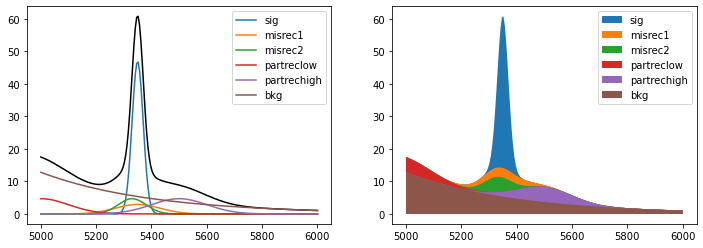

In [1]:
import numpy as np
from scipy.stats import norm, expon, crystalball
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import matplotlib as mpl

# set the default color cycle
#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "r", "g", "c", "m", "y"]) 


np.random.seed(1)  # fix seed

# ranges
mrange = (5000,6000)

# tot events
nevents = 10000

# components of the PDF
compnames = ['sig','misrec1','misrec2','partreclow','partrechigh','bkg']

               
pdf_typs = {'sig'          : norm, 
            'misrec1'      : norm,
            'misrec2'      : norm,
            'partreclow'   : crystalball,
            'partrechigh'  : crystalball,
            'bkg'          : expon
          }

pdf_vars = {'sig'          : (5350,20), 
            'misrec1'      : (5350,80),
            'misrec2'      : (5330,50),
            'partreclow'   : (3 , 2 , 5000, 100),
            'partrechigh'  : (3, 2 , 5500, 100),
            'bkg'          : (5000, 400)
          }

pdf_dic = { name: pdf_typs[name](*pdf_vars[name]) for name in compnames}

# frac_yields
frac_ylds = { 'sig'          : 0.2, 
              'misrec1'      : 0.05,
              'misrec2'      : 0.05,
              'partreclow'   : 0.05,
              'partrechigh'  : 0.1,
              'bkg'          : 0.4
          }

# normalise yields
norm_sum = sum(frac_ylds.values())
for name in compnames: frac_ylds[name] /= norm_sum 

# set yields
abs_ylds = { name : frac_ylds[name]*nevents for name in compnames }
print(abs_ylds)

# set normalisations
pdf_norms = { name : np.diff( pdf_dic[name].cdf(mrange))[0] for name in compnames }

# define a pdf function
def pdf(x, comps='all'):
    if comps=='all': comps = compnames
    return sum( [ abs_ylds[comp] * pdf_dic[comp].pdf(x) / pdf_norms[comp] for comp in comps ] )    

# draw the pdf(s)
fig, ax = plt.subplots(1,2, figsize=(12,4))
m = np.linspace(*mrange,200)

ax[0].plot(m, pdf(m), 'k-' )
for comp in compnames: ax[0].plot(m, pdf(m,comps=[comp]), label=comp)
ax[0].legend()

rcomps = list(compnames)
for comp in compnames: 
    ax[1].fill_between(m, pdf(m, comps=rcomps), label=comp)
    rcomps.remove(comp)
ax[1].legend()


17.433259740749016 7.495969587783039


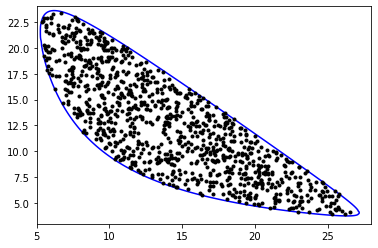

In [2]:
## Need to set up some stuff for the Dalitz distrbutions
class dalitz:
    
    def __init__(self, md, ma, mb, mc):
        self.fMa = ma
        self.fMb = mb
        self.fMc = mc
        self.fMd = md
        self.fM2a = ma*ma
        self.fM2b = mb*mb
        self.fM2c = mc*mc
        self.fM2d = md*md
        self.fM2sum = self.fM2a + self.fM2b + self.fM2c + self.fM2d
        self.abrange = (np.floor((self.fMa + self.fMb)**2) , np.ceil((self.fMd - self.fMc)**2))
        self.bcrange = (np.floor((self.fMb + self.fMc)**2) , np.ceil((self.fMd - self.fMa)**2))
        self.acrange = (np.floor((self.fMa + self.fMc)**2) , np.ceil((self.fMd - self.fMb)**2))
        
    def in_kine_limits(self, m2ab, m2ac):
        #passes = (self.fM2sum < m2ab+m2ac)
        #passes = (m2ab > self.abrange[0]) & (m2ab < self.abrange[1])
        #passes = passes & (m2ab > self.abrange[0]) & (m2ab < self.abrange[1])
        m2bc = self.fM2sum - m2ab -m2ac
        #m2bc[ m2bc < 0 ] = 0
        mab = m2ab**0.5
        mac = m2ac**0.5
        mbc = m2bc**0.5     

        p2a = 0.25/self.fM2d*(self.fM2d-(mbc+self.fMa)**2)*(self.fM2d-(mbc-self.fMa)**2)
        p2b = 0.25/self.fM2d*(self.fM2d-(mac+self.fMb)**2)*(self.fM2d-(mac-self.fMb)**2)
        p2c = 0.25/self.fM2d*(self.fM2d-(mab+self.fMc)**2)*(self.fM2d-(mab-self.fMc)**2)
        #print( p2a, p2b, p2c)
        #passes = passes & (p2a > 0) & (p2b > 0) & (p2c > 0)
        
        eb = (m2ab-self.fM2a+self.fM2b)/2./mab
        ec = (self.fM2d-m2ab-self.fM2c)/2./mab
        if ( eb < self.fMb ) or ( ec < self.fMc ): return False
        #passes = passes & (eb > self.fMb) & (ec > self.fMc)
        
        pb = np.sqrt(eb**2-self.fM2b)
        pc = np.sqrt(ec**2-self.fM2c)
        e2sum = (eb+ec)**2
        m2bc_max = e2sum-(pb-pc)**2
        m2bc_min = e2sum-(pb+pc)**2
        if m2bc < m2bc_min or m2bc > m2bc_max: return False
        if (p2a>0 and p2b>0 and p2c>0): return True
        #passes = passes & (m2bc > m2bc_min) & (m2bc < m2bc_max)
        return False

    def dp_contour(self, x, y, orientation=1323):
        
        mParent = self.fMd
        if orientation == 1323:
            mi = self.fMa
            mj = self.fMb
            mk = self.fMc
        elif orientation == 2313:
            mi = self.fMb
            mj = self.fMa
            mk = self.fMc
        elif orientation == 1213:
            mi = self.fMb
            mj = self.fMc
            mk = self.fMa
        elif orientation == 1312:
            mi = self.fMc
            mj = self.fMb
            mk = self.fMa
        elif orientation == 1223:
            mi = self.fMa
            mj = self.fMc
            mk = self.fMb
        elif orientation == 2312:
            mi = self.fMc
            mj = self.fMa
            mk = self.fMb
        else:
            raise RuntimeError('Invalid orientation', orientation)
                       
        mik = np.sqrt(x)
        mjk = np.sqrt(y)
        
        ejcmsik = (mParent*mParent-mj*mj-mik*mik)/(2.0*mik)
        ekcmsik = (mik*mik+mk*mk-mi*mi)/(2.0*mik)
        
        pj = np.sqrt(np.abs(ejcmsik*ejcmsik-mj*mj))
        pk = np.sqrt(np.abs(ekcmsik*ekcmsik-mk*mk))
        
        coshelik = (mjk*mjk - mk*mk - mj*mj - 2.0*ejcmsik*ekcmsik)/(2.0*pj*pk)
        coshelikSq = coshelik*coshelik
        
        coshelikSq = np.where( ekcmsik < mk , 2. , coshelikSq )
        coshelikSq = np.where( ejcmsik < mj  , 2. , coshelikSq )
        return np.where( np.isnan(coshelikSq), 2., coshelikSq )
    
    def psgen(self, size=1):
        
        res = np.empty((0,2))
        for i in range(size):
            x = np.random.uniform( *self.abrange )
            y = np.random.uniform( *self.acrange )
            while not self.in_kine_limits(x,y):
                x = np.random.uniform( *self.abrange )
                y = np.random.uniform( *self.acrange )
            
            res = np.append(res,[[x,y]],axis=0)
        return res
    
## pretend this is Bs -> D0 K pi
mB = 5.350
mD = 1.800
mK = 0.493
mPi = 0.139

bdkp = dalitz( mB, mD, mK, mPi )

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)
plt.contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('b'))
vals = bdkp.psgen(size=1000)
plt.plot(vals[:,0], vals[:,1],'.',color='k')

tx, ty = bdkp.psgen()[0]
print(tx, ty)

In [3]:
## Generate a toy
import pandas as pd

data = pd.DataFrame(columns=['mass','ctrl','m2ab','m2ac'])
#data = pd.DataFrame.astype({'mass':float,'ctrl':int,'m2ab':float,'m2ac':float})



for i, comp in enumerate(compnames):
    nevs = np.random.poisson(abs_ylds[comp])
    ngen = 0
    while ngen<nevs:
        mval = pdf_dic[comp].rvs()
        if mval>=mrange[0] and mval<=mrange[1]:
            ctrl = i
            if ctrl==0:
                x = np.random.normal(10,0.2)
                y = np.random.uniform(*bdkp.acrange)
                while not bdkp.in_kine_limits(x,y):
                    x = np.random.normal(10,0.2)
                    y = np.random.uniform(*bdkp.acrange)
            elif ctrl==4:
                x = np.random.uniform(*bdkp.abrange)
                y = np.random.normal(15,0.4) 
                while not bdkp.in_kine_limits(x,y):
                    x = np.random.uniform(*bdkp.abrange) 
                    y = np.random.normal(15,0.4)
            else:
                x,y = bdkp.psgen()[0]                
                        
            data = data.append( {'mass':mval, 'ctrl': ctrl, 'm2ab':x, 'm2ac':y}, ignore_index=True )            
            ngen += 1
            
print(data)


            

             mass  ctrl       m2ab       m2ac
0     5350.344164   0.0  10.035083  19.672321
1     5352.829888   0.0   9.585293  20.535525
2     5312.754809   0.0   9.960660  13.018519
3     5362.356717   0.0  10.127755  20.027217
4     5369.952230   0.0  10.018305   9.508347
...           ...   ...        ...        ...
9995  5509.504721   5.0  17.470321  11.844737
9996  5572.127225   5.0  12.976423  17.006859
9997  5599.912556   5.0  24.462905   4.652797
9998  5066.131713   5.0  15.207718   9.045130
9999  5490.784733   5.0  17.607931  11.376197

[10000 rows x 4 columns]


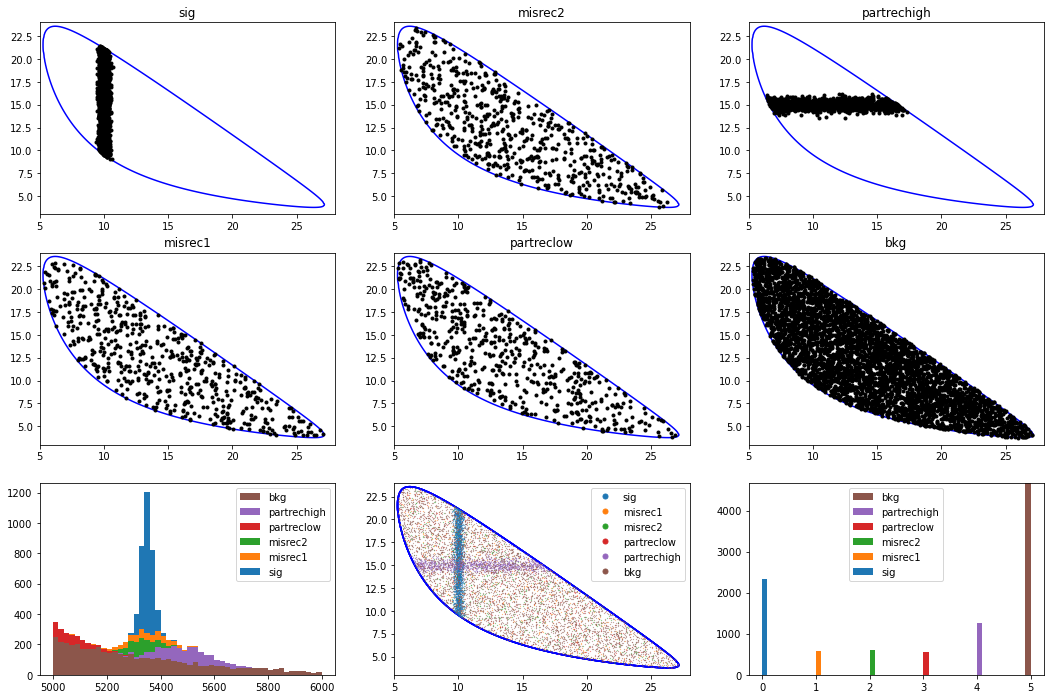

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(18,12))

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)

for i, comp in enumerate(compnames): 
    plax = ( i%2, int(i/2) )
    ax[plax].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('b'))
    dslice = data[data['ctrl']==i]
    ax[plax].plot( dslice['m2ab'].to_numpy(), dslice['m2ac'].to_numpy(),'.', color='k' )
    ax[plax].set_title(comp)
    ax[2,1].plot( dslice['m2ab'].to_numpy(), dslice['m2ac'].to_numpy(), '.' , markersize=0.4,  label=comp)
    ax[2,1].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('b'))
    
legend = ax[2,1].legend(frameon=True)
cols = []
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_markersize(10)
    cols.append(legend_handle._legmarker.get_color())
    
ax[2,0].hist( tuple( data[data['ctrl']==i]['mass'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=50, range=mrange, stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[2,0].legend()

ax[2,2].hist( tuple( data[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=50, range=(0,len(compnames)-1), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[2,2].legend()



## Now fit the data

Going to fix all the shapes for simplicity but note these could be changed

In [5]:
from iminuit import Minuit

def nll(sigy, misrec1y, misrec2y, partreclowy, partrechighy, bkgy):
    
    s = pdf_dic['sig']
    mr1 = pdf_dic['misrec1']
    mr2 = pdf_dic['misrec2']
    pr1 = pdf_dic['partreclow']
    pr2 = pdf_dic['partrechigh']
    b = pdf_dic['bkg']
    sn = np.diff( s.cdf(mrange))
    bn = np.diff( b.cdf(mrange))
    mr1n = np.diff( mr1.cdf(mrange))
    mr2n = np.diff( mr2.cdf(mrange))
    pr1n = np.diff( pr1.cdf(mrange))
    pr2n = np.diff( pr2.cdf(mrange))
    no = sigy + bkgy + misrec1y + misrec2y + partreclowy + partrechighy
    ne = np.sum(np.log(s.pdf(data['mass'].to_numpy()) / sn * sigy + 
                       b.pdf(data['mass'].to_numpy()) / bn * bkgy +
                       mr1.pdf(data['mass'].to_numpy()) / mr1n * misrec1y +
                       mr2.pdf(data['mass'].to_numpy()) / mr2n * misrec2y +
                       pr1.pdf(data['mass'].to_numpy()) / pr1n * partreclowy +
                       pr2.pdf(data['mass'].to_numpy()) / pr2n * partrechighy
                      )
               )
    
    #nev = sum( [ np.log(pdf.pdf(data['mass'].to_numpy))])
    #ne = np.sum( np.log( pdfs[0].pdf(data['mass'].to_numpy())))
    #ne = np.sum(sum([np.log(pdf.pdf(data['mass'].to_numpy()) / pdf_norms[i] * ylds[i]) for i,pdf in enumerate(pdfs)]))
    return no-ne

mikwargs = {}
for name in compnames:
    #if 'part' in name: continue
    mikwargs[name+'y'] = abs_ylds[name]
    mikwargs['limit_'+name+'y'] = (0.5*abs_ylds[name],2.5*abs_ylds[name])

# fix the misrec yields as we might do in an analysis
mikwargs['fix_misrec1y'] = True
mikwargs['fix_misrec2y'] = True
                 
mi = Minuit(nll, **mikwargs,
            errordef=Minuit.LIKELIHOOD,
            pedantic=False)
                 
display(mi.migrad())
mi.hesse()

# set the fitted yields as our yields
for comp in compnames:
    abs_ylds[comp] = mi.values[comp+'y']
    


------------------------------------------------------------------
| FCN = -1.752E+04              |      Ncalls=93 (93 total)      |
| EDM = 1.81E-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
|   | Name         |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------
| 0 | sigy         |   2350    |    60     |            |            | 1176.47 | 5882.35 |       |
| 1 | misrec1y     |   588.2   |    1.0    |            |            | 294.118 | 1470.59 |  yes  |
| 2 | misrec2y     |   588.2   |    1.0    |            |            | 294.118 | 1470.59 |  yes  |
| 3 | partreclowy  |    440    |    80     |            |            | 294.118 | 1470.59 |       |
| 4 | partrechighy |   1300    |    70     |            |            | 588.235 | 2941.18 |       |
| 5 | bkgy         |  0.472E4  |  0.015E4  |            |            | 2352.94 | 11764.7 |       |
--------------------------------------------------------------------------------------------------

## Now compute the sWeights

In [6]:
### Now do the sWeights
import importlib
import MySWeightClass
MySWeightClass = importlib.reload(MySWeightClass)
from MySWeightClass import SWeight


pdfs = [ pdf_dic[comp] for comp in compnames]
ylds = [ abs_ylds[comp] for comp in compnames]

sw = SWeight(data['mass'].to_numpy(), pdfs=pdfs, yields=ylds, method='summation', discvarranges=(mrange,), compnames=compnames)


Initialising SWeighter with the summation method:
    W-matrix:
	[[2.82728407e-04 1.15037954e-04 1.59795934e-04 5.80831071e-07
	  3.31564990e-05 2.75470446e-05]
	 [1.15037954e-04 1.93166240e-04 1.88637929e-04 1.40168675e-05
	  1.14322574e-04 7.74479164e-05]
	 [1.59795934e-04 1.88637929e-04 2.36419720e-04 7.66886552e-06
	  5.50953869e-05 6.47004045e-05]
	 [5.80831071e-07 1.40168675e-05 7.66886552e-06 4.08305340e-04
	  1.23066169e-06 1.70696470e-04]
	 [3.31564990e-05 1.14322574e-04 5.50953869e-05 1.23066169e-06
	  3.16274960e-04 8.69784053e-05]
	 [2.75470446e-05 7.74479164e-05 6.47004045e-05 1.70696470e-04
	  8.69784053e-05 1.40605516e-04]]
    alpha-matrix:
	[[  6013.27672822   2209.80034517  -6108.94054991   -744.85034752
	    -873.74188346   1860.51371038]
	 [  2209.80034517  40436.62946763 -30382.64123867   1594.3041065
	   -7988.87116244  -5718.97761828]
	 [ -6108.94054991 -30382.64123867  31761.0372209    1696.61351853
	    6913.66590783  -3019.38376164]
	 [  -744.85034752   1594.3

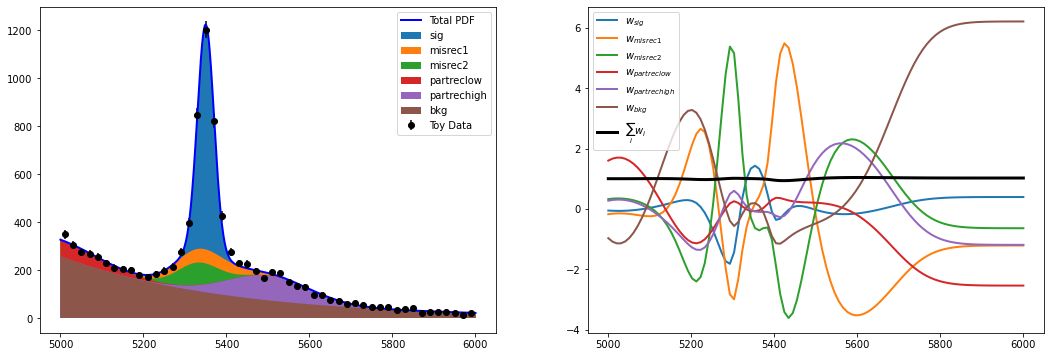

In [7]:
## Now make a plot of the fit result and sweights

# draw the fit result
fig, ax = plt.subplots(1,2,figsize=(18,6))
w, xe = np.histogram( data['mass'].to_numpy(), bins=50, range=mrange )
cx = 0.5 * (xe[1:] + xe[:-1])
# bin width to normalise mass_pdf for plotting
x = np.linspace(*mrange,1000)
pdfnorm = (mrange[1]-mrange[0])/50

rcomps = list(compnames)
for comp in compnames: 
    ax[0].fill_between(x, pdfnorm*pdf(x, comps=rcomps), label=comp)
    rcomps.remove(comp)
ax[0].errorbar( cx, w, w**0.5, fmt='ko', label='Toy Data')
ax[0].plot( x, pdfnorm*pdf(x),'b-', linewidth=2, label='Total PDF')
ax[0].legend()

dopts = [ c for c in cols]
sw.makeWeightPlot(ax[1],dopts)




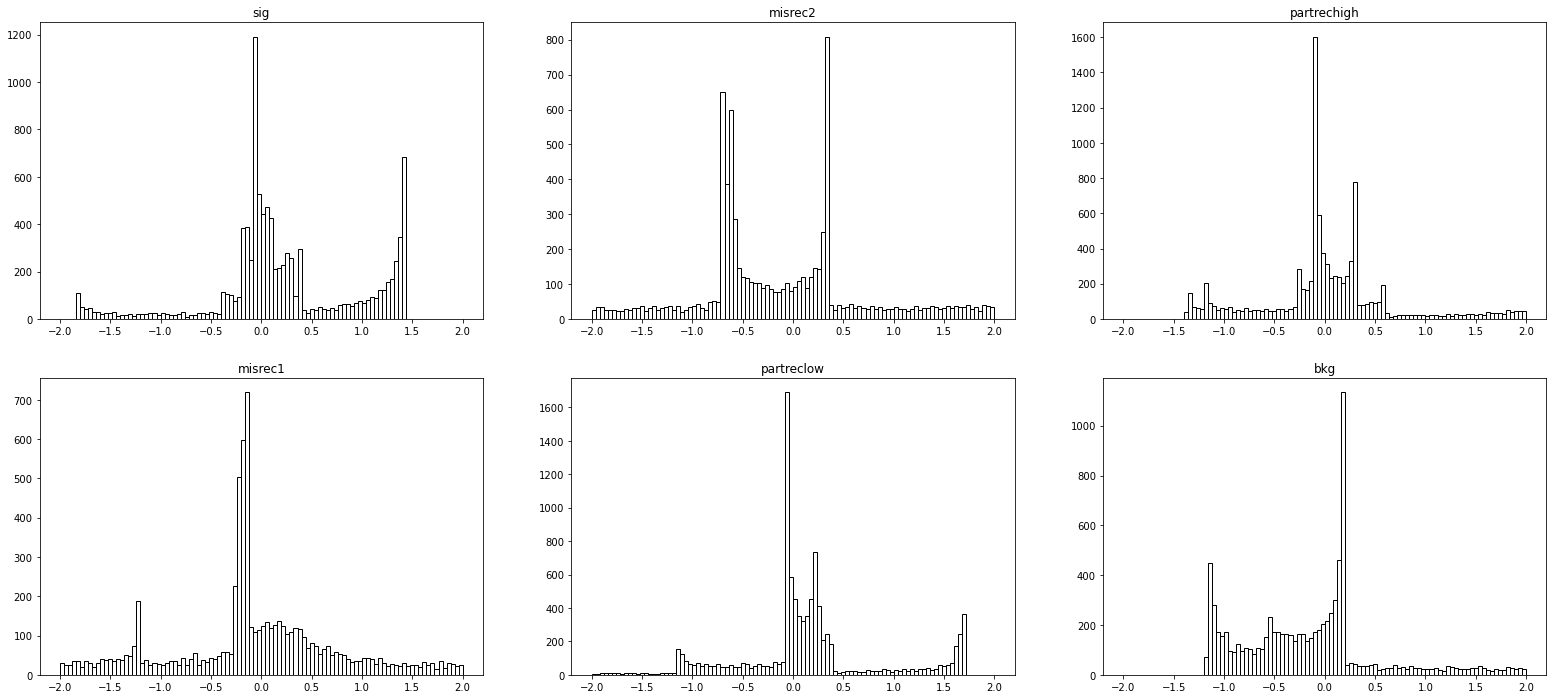

In [8]:
### Look at the distribution of the weights themselves
fig, ax = plt.subplots(2, 3, figsize=(27,12))

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    ax[plax].hist( sw.getWeight(i,data['mass'].to_numpy()), bins=100, range=(-2,2.), fill=False)
    ax[plax].set_title(comp)

Component    | SW       | SumSW    | Fit      | Truth    |
__________________________________________________________
sig          |  2378.06 |  2351.53 |  2351.53 |  2342.00 |
misrec1      |   557.88 |   588.24 |   588.24 |   568.00 |
misrec2      |   697.21 |   588.24 |   588.24 |   609.00 |
partreclow   |   540.50 |   435.71 |   435.71 |   558.00 |
partrechigh  |  1222.34 |  1299.39 |  1299.39 |  1250.00 |
bkg          |  4759.14 |  4723.98 |  4723.98 |  4673.00 |


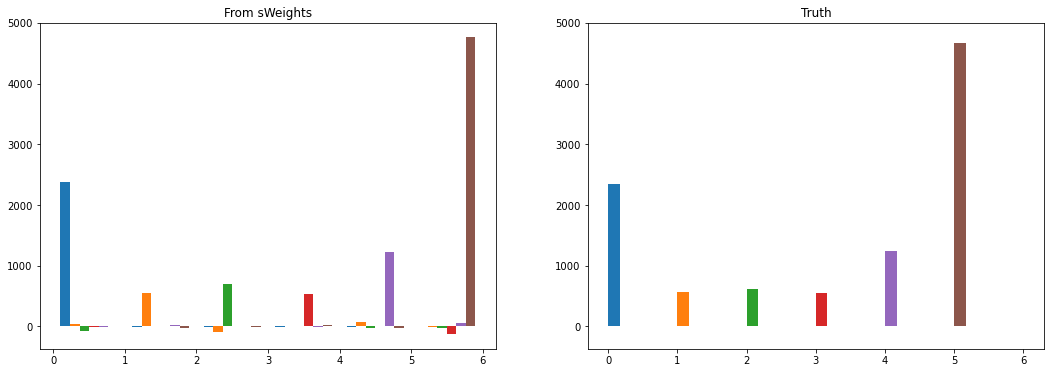

In [9]:
### Now look at sweighted distributions of ctrl variables

fig, ax = plt.subplots(1,2,figsize=(18,6))

dum1 = ax[0].hist( [data['ctrl'].to_numpy() for i in compnames], bins=6, range=(0,6), weights=[sw.getWeight(i, data['mass'].to_numpy()) for i, comp in enumerate(compnames)])
ax[0].set_title("From sWeights")

dum2 = ax[1].hist( tuple( data[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=36, range=(0,6), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title("Truth")

head = '{:12s} | {:8s} | {:8s} | {:8s} | {:8s} |'.format('Component','SW','SumSW','Fit','Truth')
print(head)
print( '_'.join([ '' for i in range(len(head)+1) ]))
for i, comp in enumerate(compnames):
    print('{:12s} |'.format(comp), 
          '{:8.2f} |'.format(dum1[0][i][i]), 
          '{:8.2f} |'.format(sum(dum1[0][i])),
          '{:8.2f} |'.format(abs_ylds[comp]), 
          '{:8.2f} |'.format(dum2[0][-1][i*6]))


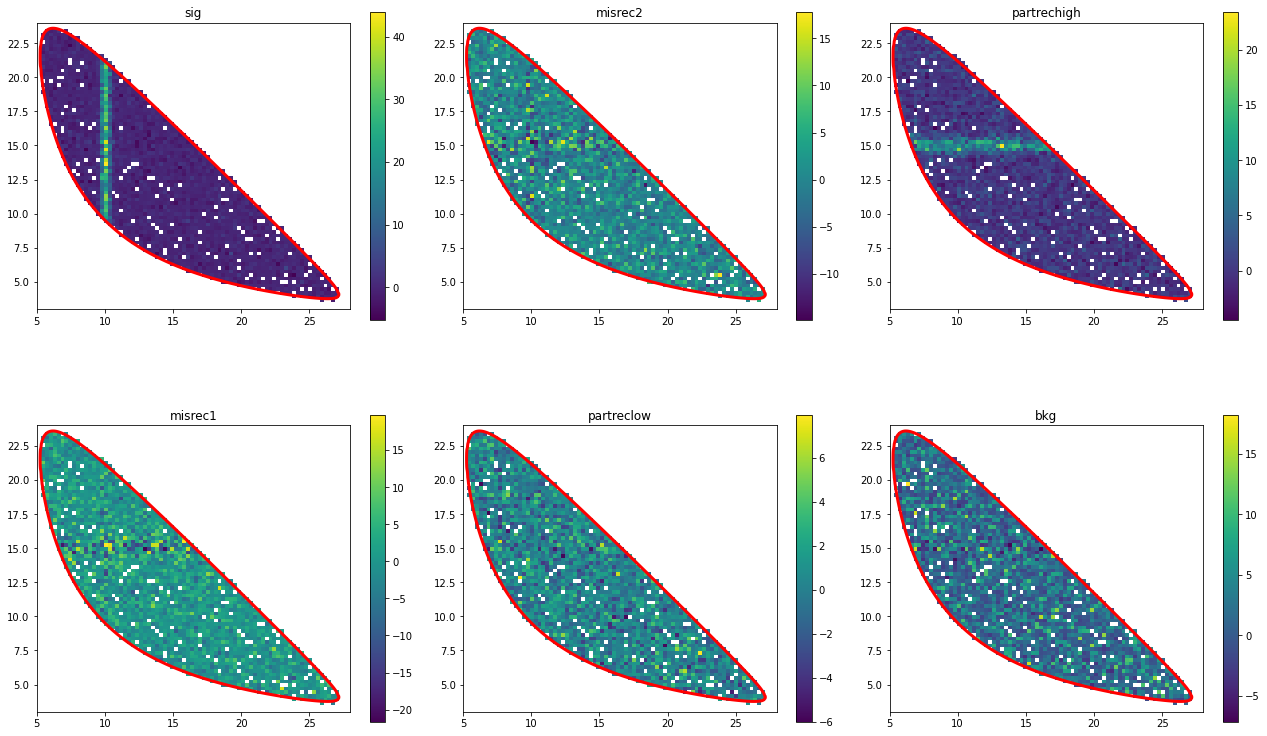

In [10]:
# dalitz plots of ctrl variables
from matplotlib import colors
fig, ax = plt.subplots(2, 3, figsize=(18,12))

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    h, xe, ye = np.histogram2d( data['m2ab'].to_numpy(), data['m2ac'].to_numpy(), weights=sw.getWeight(i, data['mass'].to_numpy()), bins=[80,80], range=(bdkp.abrange,bdkp.acrange) )
    h[h==0] = np.nan
    im = ax[plax].imshow(h.T, interpolation='nearest', origin='low', extent=[xe[0], xe[-1], ye[0], ye[-1]])#, vmin=-30, vmax=50)
    ax[plax].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('r'),linewidths=(3))
    ax[plax].set_title(comp)
    fig.colorbar(im, ax=ax[plax], shrink=0.7)

fig.tight_layout()



## Can now see what happens if we do this in a narrow range

Initialising SWeighter with the summation method:
    W-matrix:
	[[2.82728407e-04 1.16483907e-04 1.59822228e-04 4.34707056e-06
	  4.79985843e-05 5.82020117e-05]
	 [1.16483907e-04 1.97889409e-04 1.91037990e-04 9.11462314e-05
	  1.63871787e-04 1.62161297e-04]
	 [1.59822228e-04 1.91037990e-04 2.36497439e-04 5.70664791e-05
	  7.97677369e-05 1.36662380e-04]
	 [4.34707056e-06 9.11462314e-05 5.70664791e-05 1.12637019e-03
	  9.39113485e-06 3.70520573e-04]
	 [4.79985843e-05 1.63871787e-04 7.97677369e-05 9.39113485e-06
	  4.41715968e-04 1.64614579e-04]
	 [5.82020117e-05 1.62161297e-04 1.36662380e-04 3.70520573e-04
	  1.64614579e-04 2.35557920e-04]]
    alpha-matrix:
	[[  6774.97837791   -361.10660533  -7717.77000953  -2277.25993083
	   -2207.32754705   8176.7529175 ]
	 [  -361.10660533  74094.622767   -38351.6241524    7760.24816608
	   -7376.55161176 -35719.80265074]
	 [ -7717.77000953 -38351.6241524   42471.78568144   5045.82683889
	   12007.60053439 -12660.0082694 ]
	 [ -2277.25993083   7760.

(-4.0, 6.0)

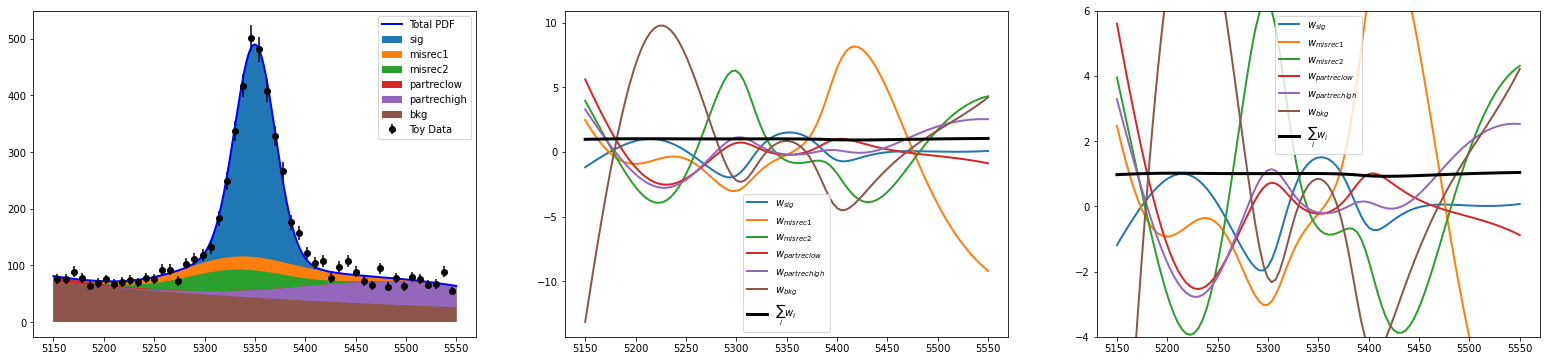

In [15]:
narrange  = ( pdf_vars['sig'][0] - 10.*pdf_vars['sig'][1], pdf_vars['sig'][0] + 10.*pdf_vars['sig'][1])
narylds   = [ ylds[i]*np.diff( pdf_dic[comp].cdf(narrange))[0]/np.diff( pdf_dic[comp].cdf(mrange))[0] for i, comp in enumerate(compnames) ]
narylddic = { comp: ylds[i]*np.diff( pdf_dic[comp].cdf(narrange))[0]/np.diff( pdf_dic[comp].cdf(mrange))[0] for i, comp in enumerate(compnames) }
narnorms  = { comp: np.diff( pdf_dic[comp].cdf(narrange))[0] for comp in compnames }

nardata = data.loc[ (data.mass >= narrange[0]) & (data.mass <= narrange[1]) ]

narsw = SWeight(nardata['mass'].to_numpy(), pdfs=pdfs, yields=narylds, method='summation', discvarranges=(narrange,), compnames=compnames)

## Now make a plot of the fit result and sweights
def narpdf(x, comps='all'):
    if comps=='all': comps = compnames
    return sum( [ narylddic[comp] * pdf_dic[comp].pdf(x) / narnorms[comp] for comp in comps ] )    

# draw the fit result
fig, ax = plt.subplots(1,3,figsize=(27,6))
w, xe = np.histogram( nardata['mass'].to_numpy(), bins=50, range=narrange )
cx = 0.5 * (xe[1:] + xe[:-1])
# bin width to normalise mass_pdf for plotting
x = np.linspace(*narrange,1000)
pdfnorm = (narrange[1]-narrange[0])/50

rcomps = list(compnames)
for i, comp in enumerate(compnames): 
    ax[0].fill_between(x, pdfnorm*narpdf(x, comps=rcomps), label=comp)
    #ax[0].plot(x, pdfnorm*narpdf(x, comps=rcomps), label=comp)
    rcomps.remove(comp)
ax[0].errorbar( cx, w, w**0.5, fmt='ko', label='Toy Data')
ax[0].plot( x, pdfnorm*narpdf(x),'b-', linewidth=2, label='Total PDF')
ax[0].legend()

dopts = [ c for c in cols]
narsw.makeWeightPlot(ax[1],dopts)
narsw.makeWeightPlot(ax[2],dopts)
ax[2].set_ylim((-4,6))





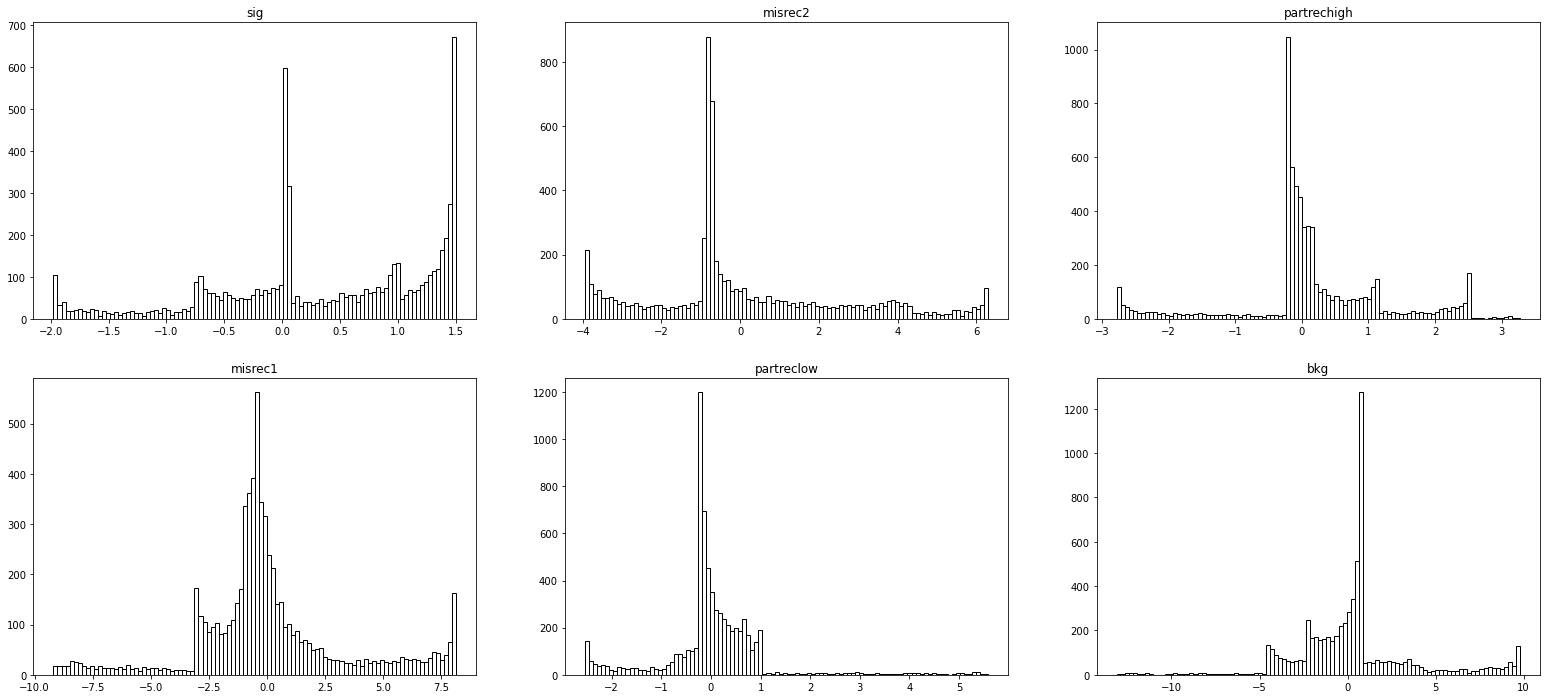

In [16]:
### Look at the distribution of the weights themselves
fig, ax = plt.subplots(2, 3, figsize=(27,12))

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    ax[plax].hist( narsw.getWeight(i,nardata['mass'].to_numpy()), bins=100, fill=False)
    ax[plax].set_title(comp)

<ipython-input-17-b664a8297cad>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dum2 = ax[1].hist( tuple( nardata[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=36, range=(0,6), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))


Component    | SW       | SumSW    | Fit      | Truth    |
__________________________________________________________
sig          |  2383.49 |  2351.53 |  2351.53 |  2342.00 |
misrec1      |   558.56 |   580.93 |   580.93 |   559.00 |
misrec2      |   719.48 |   588.14 |   588.14 |   609.00 |
partreclow   |    55.30 |    58.22 |    58.22 |    81.00 |
partrechigh  |   877.25 |   897.59 |   897.59 |   898.00 |
bkg          |  2280.69 |  2235.86 |  2235.86 |  2271.00 |


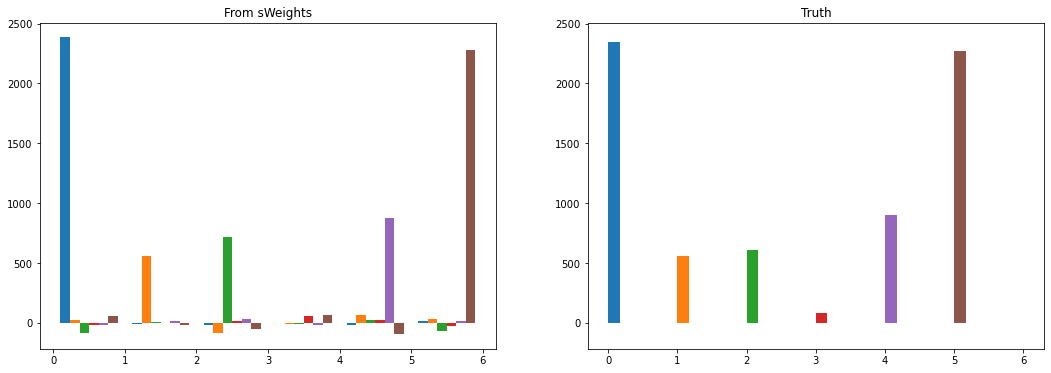

In [17]:
### Now look at sweighted distributions of ctrl variables

fig, ax = plt.subplots(1,2,figsize=(18,6))

dum1 = ax[0].hist( [nardata['ctrl'].to_numpy() for i in compnames], bins=6, range=(0,6), weights=[narsw.getWeight(i, nardata['mass'].to_numpy()) for i, comp in enumerate(compnames)])
ax[0].set_title("From sWeights")

dum2 = ax[1].hist( tuple( nardata[data['ctrl']==i]['ctrl'].to_numpy() for i in reversed(range(len(compnames))) ) , bins=36, range=(0,6), stacked=True, color=tuple(reversed(cols)), label=tuple(reversed(compnames)))
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title("Truth")

head = '{:12s} | {:8s} | {:8s} | {:8s} | {:8s} |'.format('Component','SW','SumSW','Fit','Truth')
print(head)
print( '_'.join([ '' for i in range(len(head)+1) ]))
for i, comp in enumerate(compnames):
    print('{:12s} |'.format(comp), 
          '{:8.2f} |'.format(dum1[0][i][i]), 
          '{:8.2f} |'.format(sum(dum1[0][i])),
          '{:8.2f} |'.format(narylddic[comp]), 
          '{:8.2f} |'.format(dum2[0][-1][i*6]))



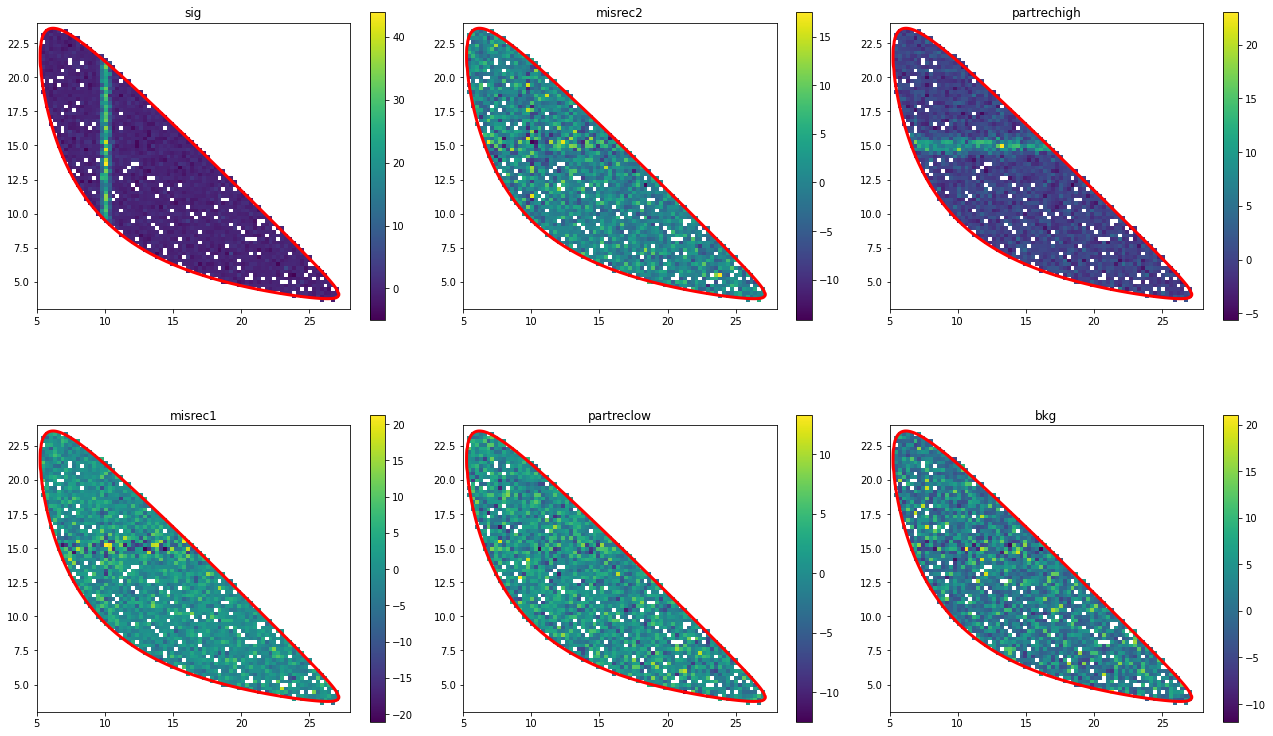

In [14]:
# dalitz plots of ctrl variables
from matplotlib import colors
fig, ax = plt.subplots(2, 3, figsize=(18,12))

m12 = np.linspace(*bdkp.abrange,400)
m13 = np.linspace(*bdkp.acrange,400)

x,y = np.meshgrid(m12,m13)

for i, comp in enumerate(compnames):
    plax = (i%2, int(i/2))
    h, xe, ye = np.histogram2d( nardata['m2ab'].to_numpy(), nardata['m2ac'].to_numpy(), weights=narsw.getWeight(i, nardata['mass'].to_numpy()), bins=[80,80], range=(bdkp.abrange,bdkp.acrange) )
    h[h==0] = np.nan
    im = ax[plax].imshow(h.T, interpolation='nearest', origin='low', extent=[xe[0], xe[-1], ye[0], ye[-1]])#, vmin=-30, vmax=50)
    ax[plax].contour(x,y,bdkp.dp_contour(x,y,orientation=1213),[1.],colors=('r'),linewidths=(3))
    ax[plax].set_title(comp)
    fig.colorbar(im, ax=ax[plax], shrink=0.7)

fig.tight_layout()